In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [4]:
import numpy as np 
import scipy.fft
from operators.setup_FOM import SimulationSetupFOM
from operators.poisson_solver import gmres_solver
from operators.FOM import psi_ln_aw, charge_density, total_mass, total_momentum, total_energy_k

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# weak Landau damping FOM

In [303]:
setup = SimulationSetupFOM(Nx=151,
                           Nv=50,
                           epsilon=1e-2,
                           alpha_e=0.5,
                           alpha_i=np.sqrt(2 / 1836),
                           u_e=0,
                           u_i=0,
                           L=2 * np.pi,
                           dt=1e-2,
                           T0=0,
                           T=80,
                           nu=10,
                           problem_dir="weak_landau", 
                           construct_B=False)

In [304]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [305]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(10**4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)

# simulation results

In [306]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_t_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(7550, 8001)
(8001,)


In [307]:
runtime = np.load("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([2389.443469  ,  442.58452177])

In [308]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [309]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))

# unwind the flattening to solve the Vlasov-Poisson system
# electrons
state_e_midpoint[:, :-1, :] = np.reshape(sol_midpoint_u, (setup.Nv, setup.Nx, len(sol_midpoint_t)))
# periodicity enforced
state_e_midpoint[:, -1, :] = state_e_midpoint[:, 0, :]

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    # periodicity enforced
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density(alpha_e=setup.alpha_e, alpha_i=setup.alpha_i,
                                        q_e=setup.q_e, q_i=setup.q_i,
                                        C0_e=state_e_midpoint[0, :setup.Nx, ii],
                                        C0_i=C0_ions)
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, atol=1e-12, rtol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

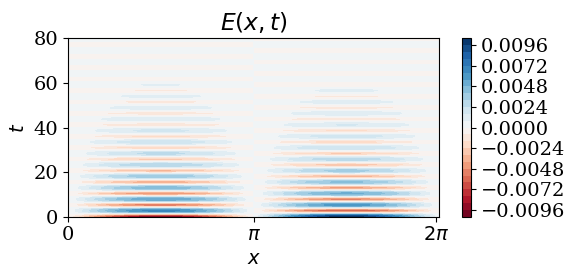

In [310]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

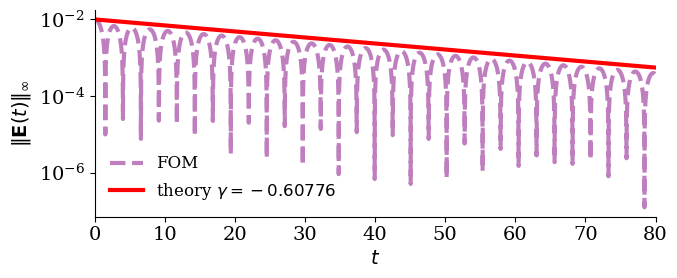

In [311]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.max(E_midpoint, axis=0), "--", c="purple", alpha=0.5, linewidth=3, label="FOM") 
ax.plot(sol_midpoint_t, 0.01*np.exp(-0.0362*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = -0.60776$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\|\mathbf{E}(t)\|_{\infty}$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.tight_layout()

In [312]:
# save the electric field
np.save("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/E_FOM_" + str(setup.Nv) + ".npy", E_midpoint)

# conservation laws: mass, momentum, and energy

### mass conservation

In [245]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx)\
                        +total_mass(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx)

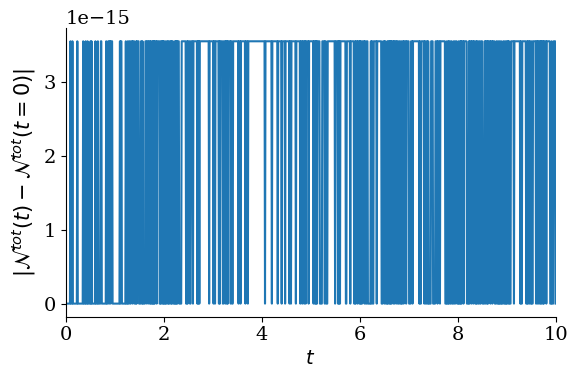

In [246]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [247]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e_midpoint[:, :, ii], alpha_s=setup.alpha_e, dx=setup.dx,
                                           m_s=setup.m_e, u_s=setup.u_e)\
                            +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=setup.alpha_i, dx=setup.dx,
                                           m_s=setup.m_i, u_s=setup.u_i)

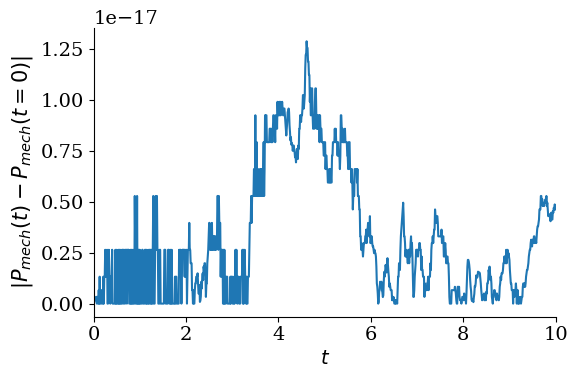

In [248]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [249]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx, m_s=setup.m_e, u_s=setup.u_e)\
                           +total_energy_k(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

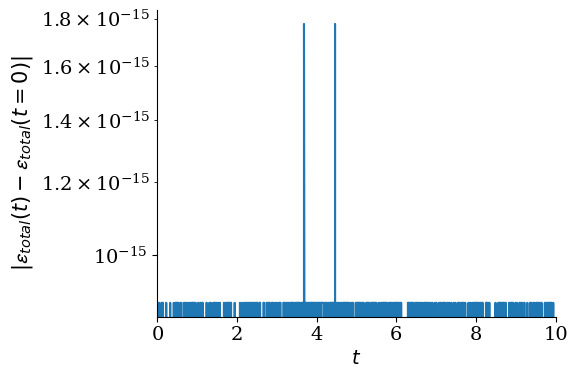

In [250]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

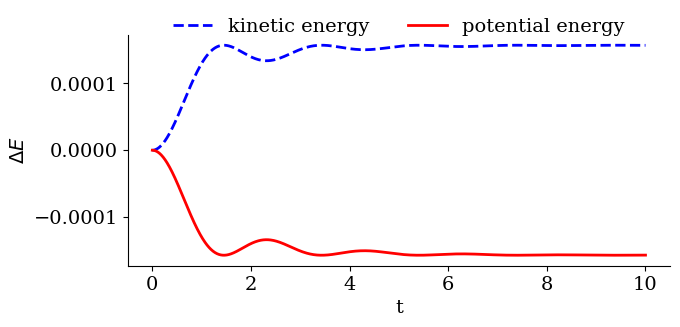

In [251]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
#ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

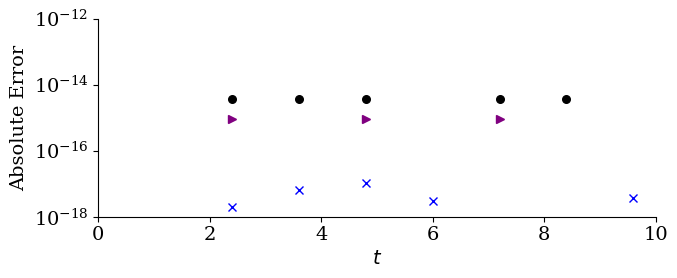

In [252]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::120], np.abs(mass_midpoint-mass_midpoint[0])[::120], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::120], np.abs(momentum_midpoint-momentum_midpoint[0])[::120], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::120], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::120], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.set_ylim(10**-20, 10**-5)
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_ylim(1e-18, 1e-12) 
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
# legend = ax.legend(ncols=2, fontsize=14, loc='upper center')
# text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
# legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/FOM/weak_landau/conservation_weak_landau_FOM.png",  bbox_inches='tight', dpi=600)

## Parameteric study 

In [253]:
alpha_train = [0.6, 0.7, 0.8, 0.9]
alpha_test  = [0.5, 0.75]

In [254]:
colors_train = plt.cm.viridis(np.linspace(0,1,len(alpha_train)))
colors_test = plt.cm.viridis(np.linspace(0,1,len(alpha_test)))

In [256]:
E_train = np.zeros((len(alpha_train), setup.Nx + 1, 1001))
E_test = np.zeros((len(alpha_train), setup.Nx + 1, 8001))

for kk in range(0, len(alpha_test)):
    # update the standard deviation parameter 
    alpha_curr = alpha_test[kk]
    E_test[kk, :, :] = np.load("../data/FOM/weak_landau/sample_" + str(alpha_curr) + "/sol_midpoint_E_" + str(setup.Nv) + ".npy")

for kk in range(0, len(alpha_train)):
    # update the standard deviation parameter 
    alpha_curr = alpha_train[kk]
    E_train[kk, :, :] = np.load("../data/FOM/weak_landau/sample_" + str(alpha_curr) + "/sol_midpoint_E_" + str(setup.Nv) + ".npy")

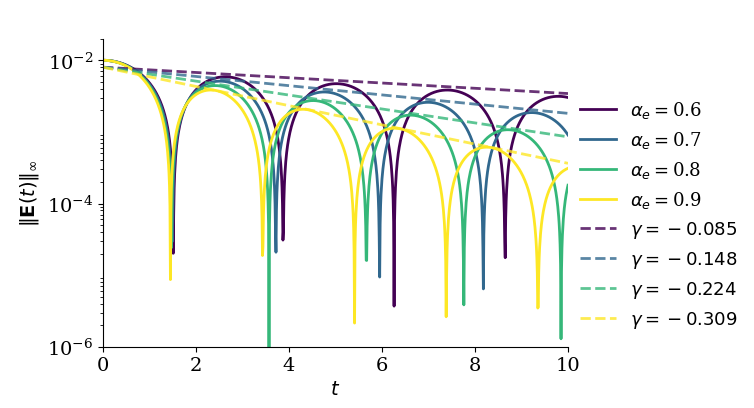

In [257]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))
for kk in range(0, len(alpha_train)):
    ax.plot(setup.t_vec[:1001], np.max(E_train[kk, :, :], axis=0), "-", linewidth=2, color=colors_train[kk], label=r"$\alpha_{e}=$" + str(round(alpha_train[kk], 1)))

ax.plot(setup.t_vec[:1001], 0.008* np.exp(-0.08467*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[0], alpha=0.8, label="$\gamma = -0.085$") 
ax.plot(setup.t_vec[:1001], 0.008*np.exp(-0.14835*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[1], alpha=0.8, label="$\gamma = -0.148$") 
ax.plot(setup.t_vec[:1001], 0.008*np.exp(-0.2238*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[2], alpha=0.8, label="$\gamma=-0.224$") 
ax.plot(setup.t_vec[:1001], 0.008*np.exp(-0.309001*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[3], alpha=0.8, label="$\gamma = -0.309$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$\|\mathbf{E}(t)\|_{\infty}$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, 10)
ax.set_yticks([1e-2, 1e-4, 1e-6])
ax.set_ylim(1e-6, 2e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13, loc='lower right', bbox_to_anchor=(1.4, 0))
legend.get_frame().set_alpha(0)
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.savefig("../figs/FOM/weak_landau/weak_landau_electric_field_FOM_train.png", bbox_inches='tight', bbox_extra_artists=(legend,text), pad_inches=0.0, dpi=600)

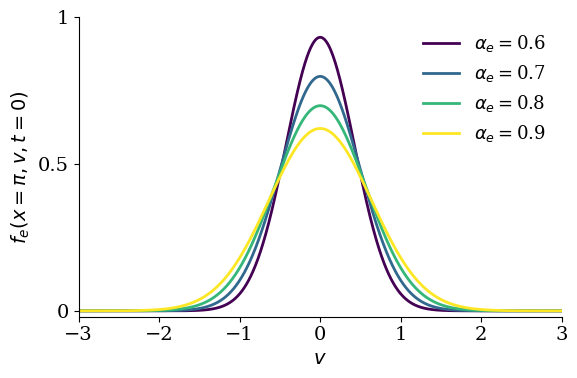

In [258]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))
for kk in range(0, len(alpha_train)):
    alpha_e = alpha_train[kk]
    C0_e = (1 + setup.epsilon * np.cos(x)) / alpha_e
    distribution = np.outer(C0_e, psi_ln_aw(v=v, alpha_s=alpha_e, u_s=setup.u_e, n=0))
    ax.plot(v, distribution[setup.Nx//2, :], linewidth=2, color=colors_train[kk], ls="-", label=r"$\alpha_{e}=$" + str(alpha_train[kk]))
    
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13,  loc='upper right')
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$f_{e}(x=\pi, v, t=0)$")
ax.set_xlabel("$v$")
ax.set_ylim(-2e-2, 1)
ax.set_xlim(-3, 3)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
plt.tight_layout()
plt.savefig("../figs/FOM/weak_landau/weak_landau_initial_condition_cross_section.png", bbox_inches='tight', pad_inches=0.0, dpi=600)

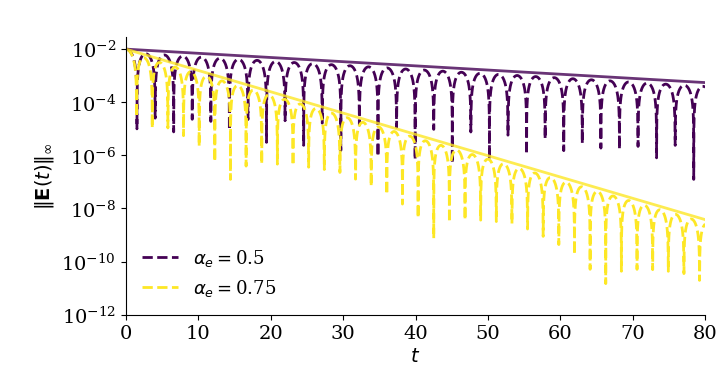

In [262]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7.5, 4))
for kk in range(0, len(alpha_test)):
    ax.plot(np.linspace(0, 80, 8001), np.max(E_test[kk, :], axis=0), "--", linewidth=2, color=colors_test[kk], label=r"$\alpha_{e}=$" + str(alpha_test[kk]))

ax.plot(np.linspace(0, 80, 8001), 0.01*np.exp(-0.03626*np.linspace(0, 80, 8001)), linewidth=2, color=colors_test[0], alpha=0.8) 
ax.plot(np.linspace(0, 80, 8001), 0.01*np.exp(-0.1848*np.linspace(0, 80, 8001)), linewidth=2, color=colors_test[1], alpha=0.8) 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\|\mathbf{E}(t)\|_{\infty}$")
ax.set_xlabel("$t$")
ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12])
ax.set_xlim(0, 80)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13, loc='lower left')
legend.get_frame().set_alpha(0)
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.tight_layout()

## POD basis 

In [263]:
# for M in range(3, 10):
#     # load the simulation results
#     sol_u_FOM  = np.load("../data/FOM/weak_landau/sample_" + str(alpha_train[0]) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(alpha_train[0]) + "_" + str(setup.T0) + "_10.npy")[M*setup.Nx:,:]
#     for kk in range(1, len(alpha_train)):
#         # update the standard deviation parameter 
#         alpha_ = alpha_train[kk]
#         new_data =  np.load("../data/FOM/weak_landau/sample_" + str(alpha_) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(alpha_) + "_" + str(setup.T0) + "_10.npy")[M*setup.Nx:, :]
#         sol_u_FOM = np.append(sol_u_FOM, new_data, axis=1)
#     # compute the SVD
#     U, S, _ = np.linalg.svd(sol_u_FOM, full_matrices=False)
#     # save the basis
#     np.save("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/basis_" + str(M) + ".npy", U)
#     np.save("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_" + str(M) + ".npy", S)

In [264]:
S_3 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_3.npy")
S_4 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_4.npy")
S_5 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_5.npy")
S_6 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_6.npy")
S_7 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_7.npy")
S_8 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_8.npy")

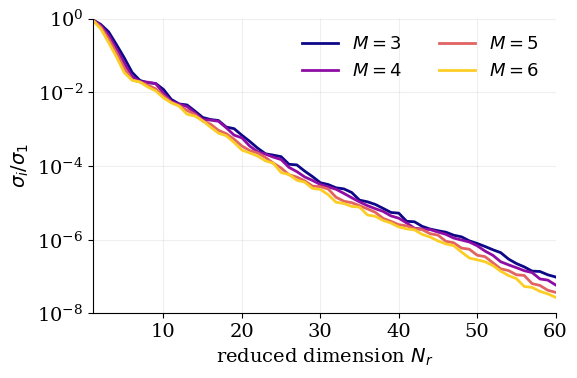

In [267]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.plasma(np.linspace(0,0.9,4))

ax.plot(np.arange(len(S_3)), (np.abs(S_3)/np.max(S_3[0])), color=colors[0],linewidth=2, label=r"$M=3$")
ax.plot(np.arange(len(S_4)), (np.abs(S_4)/np.max(S_4[0])), color=colors[1], linewidth=2, label=r"$M=4$")
ax.plot(np.arange(len(S_5)), (np.abs(S_5)/np.max(S_5[0])), color=colors[2], linewidth=2, label=r"$M=5$")
ax.plot(np.arange(len(S_6)), (np.abs(S_6)/np.max(S_6[0])), color=colors[3], linewidth=2, label=r"$M=6$")
#ax.plot(np.arange(len(S_7)), (np.abs(S_7)/np.max(S_7[0])), color=colors[4], linewidth=2, label=r"$M=7$")
#ax.plot(np.arange(len(S_8)), (np.abs(S_8)/np.max(S_8[0])), color=colors[5], linewidth=2, label=r"$M=8$")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\sigma_{i}/\sigma_{1}$")
ax.set_xlabel(r"reduced dimension $N_{r}$")
ax.set_yscale("log")
ax.set_ylim(10**-8, 1)
ax.set_xlim(1, 60)
plt.grid(alpha=0.2)
legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=13, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/singular_value_decay_weak_landau.png", dpi=300, bbox_inches='tight', pad_inches=0.0)

In [268]:
U_3 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/basis_3.npy")

In [269]:
U_3_tensor = np.zeros((setup.Nv - 3, setup.Nx, np.shape(U_3)[-1]))

In [270]:
for n in range(0, setup.Nv - 3):
    U_3_tensor[n, :, :] = U_3[n*setup.Nx: (n+1)*setup.Nx, :]

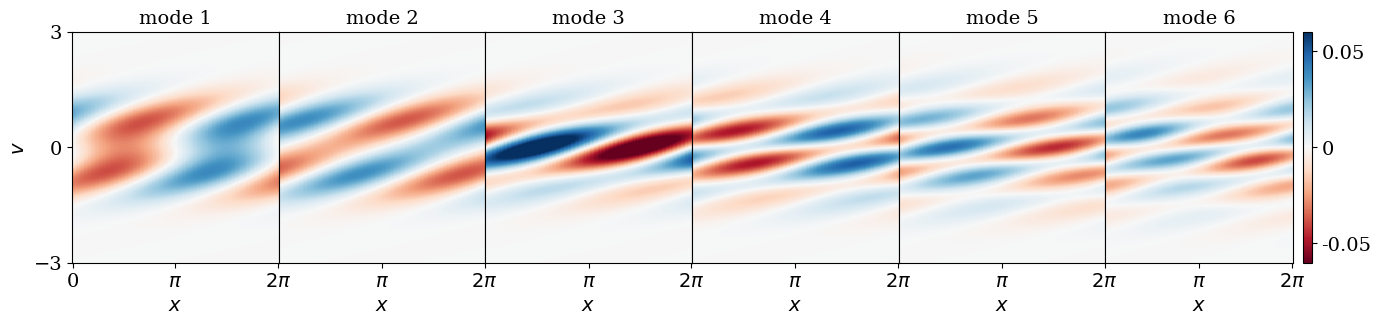

In [271]:
# plot phase space evolution 
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(ncols=6, figsize=(16, 3))
for tt, ii in enumerate([0, 1, 2, 3, 4, 5]):
    distribution = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - 3):
        distribution += np.outer(np.append(U_3_tensor[jj, :, ii], U_3_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e, alpha_s=setup.alpha_e, v=v, n=jj))
    pos = ax[tt].pcolormesh(x, v, distribution.T, cmap="RdBu", vmax=0.06, vmin=-0.06)
    ax[tt].set_xlabel("$x$")
    ax[tt].set_xticks([np.pi, 2*np.pi])
    ax[tt].set_xticklabels([r"$\pi$", r"$2\pi$"])
    ax[tt].set_yticks([])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)

# Create divider for the second subplot
divider = make_axes_locatable(ax[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add colorbar to the second subplot
cbar = plt.colorbar(pos, cax=cax)
cbar.ax.set_yticks([-0.05, 0, 0.05])
cbar.ax.set_yticklabels([-0.05, 0, 0.05])
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_yticks([-3, 0, 3])
ax[0].set_ylabel("$v$")
plt.subplots_adjust(wspace=0)
#plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/weak_landau_POD_modes.png", dpi=600, bbox_inches='tight')